# Segmentation map으로 도로 이미지 만들기

GAN을 활용한 Pix2Pix을 사용해서 segmentation map 으로부터  
이미지를 만드는 모델을 학습시켜보자.

# 0. 모듈 import

In [1]:
import os
import cv2
import glob
import imageio
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

from tensorflow import data
from tensorflow import image
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.preprocessing.image import random_rotation

# 1. 데이터 준비하기

준비한 cityscapes 데이터를 사용한다.

In [2]:
data_path = os.getenv('HOME')+'/aiffel/Exploration/E19_SegmentationMap/data/train/'
test_path = os.getenv('HOME')+'/aiffel/Exploration/E19_SegmentationMap/data/val/'

print("학습 데이터 개수 :", len(os.listdir(data_path)))
print("평가 데이터 개수 :", len(os.listdir(test_path)))

학습 데이터 개수 : 1000
평가 데이터 개수 : 5


학습 데이터 1000개와 평가 데이터 5개의 이미지로 이루어져 있다.

준비된 이미지를 출력해보자.

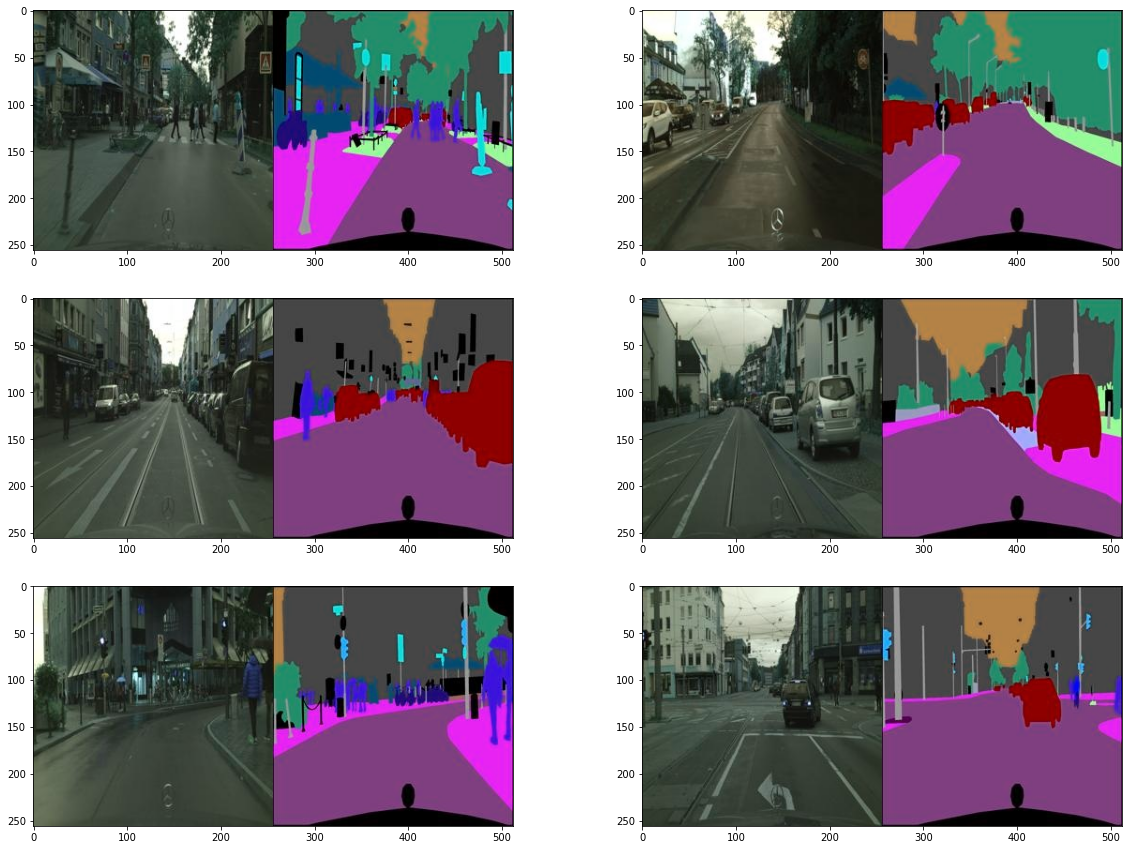

In [3]:
plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

## 2. 데이터 전처리

In [4]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f)
print(img.shape)
f'min : {img.min} , max : {img.max()}'

(256, 512, 3)


'min : <built-in method min of numpy.ndarray object at 0x7fdd5a7fb3f0> , max : 255'

하나의 데이터(이미지)마다 실제 이미지와 segmentation map 이미지가 붙었있고,  
각 이미지는 256*256 에 0~255 사이의 RGB채널을 가진다.

이미지를 실제 이미지와 입력 이미지로 분리하고 -1 ~ 1 사이의 값으로 변경하는 함수를 만들자.

In [5]:
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    colored = img[:, :w, :] 
    colored = tf.cast(colored, tf.float32)
    sketch = img[:, w:, :] 
    sketch = tf.cast(sketch, tf.float32)
    return normalize(sketch), normalize(colored)

그럼 준비된 함수로 하나의 이미지를 전처리 시켜서 출력시켜보자.

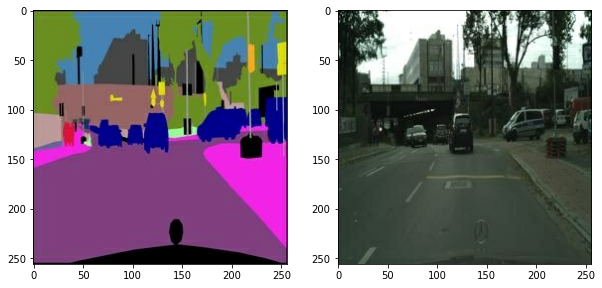

In [6]:
f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

## 3. 데이터 Augmentation

현재 학습 데이터는 1000개로 적은 편이다.  
변동성을 주어 overfit을 방지하고, 학습 데이터를 늘려서  
안정성이 늘도록 데이터 augmentation을 실시하자.

다음은 이미지에 반전, crop, 회전 등의 효과를 적용시킨 이미지를 만드는 함수이다. 

In [7]:
@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
    out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

만들어진 함수로 하나의 이미지에 대해 여러번 변화 효과를 주어 출력시켜보자.

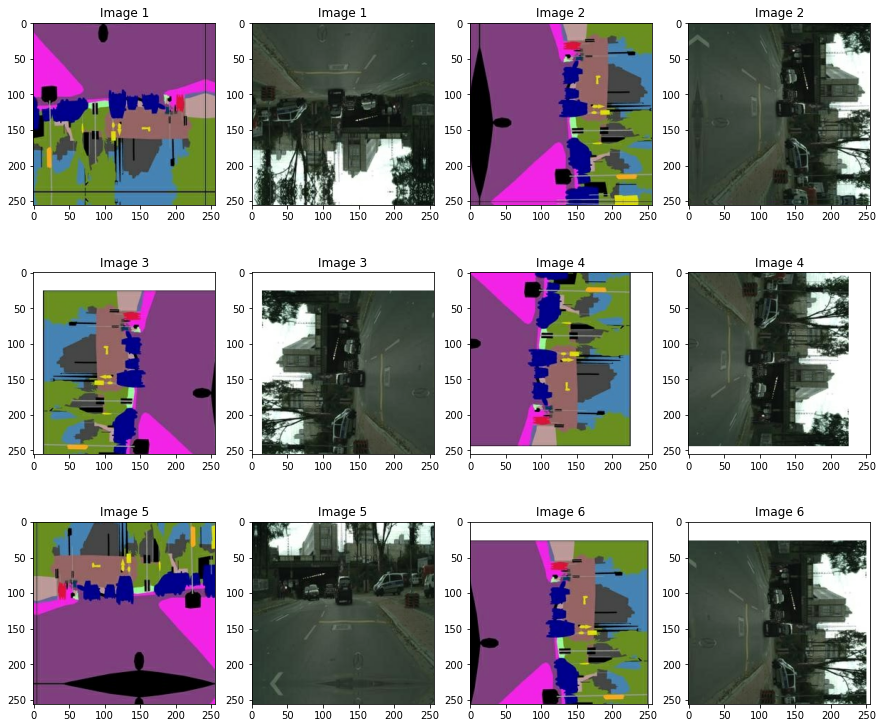

In [8]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

## 4. Dataset 구성

위에서 준비한 전처리와 agumentation 함수들을 이용해서  
train dataset과 test dataset을 만들어보자.

In [9]:
def get_augmentation(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

def create_dataset(train_path, test_path):
    train_paths = data.Dataset.list_files(train_path + "*.jpg")
    train_src = train_paths.map(load_img)
    train_arg = train_paths.map(get_augmentation)
    train_images = train_src.concatenate(train_arg).shuffle(2000).batch(4)

    test_paths = data.Dataset.list_files(test_path + "*.jpg")
    test_images = test_paths.map(load_img)
    return train_images, test_images

In [10]:
train_images, test_images = create_dataset(data_path, test_path)

# total count = batch_count * bactch_size
print(f'총 학습 데이터 개수 : {len(train_images) *train_images._batch_size.numpy()} 개')
print(f'총 평가 데이터 개수 : {len(test_images)} 개')

총 학습 데이터 개수 : 2000 개
총 평가 데이터 개수 : 5 개


의도한대로 학습데이터는 2배로 2000개가 되었다.  
그럼 만들어진 학습데이터를 하나 출력해보자.

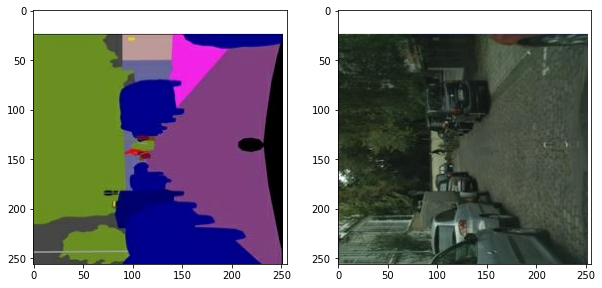

In [11]:
sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

## 5 모델 구성

In [12]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

In [13]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

### Generator

In [14]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [15]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block (EncodeBlock)      (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
encode_block_1 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block[0][0]               
__________________________________________________________________________________________________
encode_block_2 (EncodeBlock)    (None, 32, 32, 256)  525312      encode_block_1[0][0]             
______________________________________________________________________________________________

입력과 출력으로 256 * 256 *3 의 이미지가 나온 것을 확인 할 수 있다.

### Discriminator

In [16]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [17]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [18]:
Discriminator().get_summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

### Loss & Optimizer

Discriminator와 Generator의 loss함수 및 optimizer를 구현하자.

Discriminator의 경우 출력이 (30, 30, 1) 이다.  
각 한 픽셀마다 전체 이미지의 일정부분의 receptive field에 대한  
진위여부를 확률로 나타낸 것이다.

따라서 loss도 이에 맞춰서 (30, 30, 1)의 진짜면 1, 가짜면 0으로 만든다.  
accuracy의 경우 30 * 30의 확률들의 평균이 0.5이상이면 맞췄다고 가정한다.

In [19]:
bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

def get_disc_accuracy(real_disc, fake_disc):
    real_eval = tf.math.greater_equal(tf.reduce_mean(real_disc, axis=(-3, -2)), tf.constant([0.5]))
    real_accuracy = tf.reduce_mean(tf.cast(real_eval, tf.float32))
    fake_eval = tf.math.less(tf.reduce_mean(fake_disc, axis=(-3, -2)), tf.constant([0.5]))
    fake_accuracy = tf.reduce_mean(tf.cast(fake_eval, tf.float32))
    return real_accuracy, fake_accuracy

In [20]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
        real_accuracy, fake_accuracy = get_disc_accuracy(real_disc, fake_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss, real_accuracy, fake_accuracy

## 6. 학습 및 평가

준비된 모델을 학습시키자.  
학습이 길어질수 있으므로 10epoch 마다 체크포인트를 만들도록하자.

In [21]:
EPOCHS = 100

generator = UNetGenerator()
discriminator = Discriminator()

In [22]:
checkpoint_dir = 'save/'

checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=gene_opt,
                                discriminator_optimizer=disc_opt,
                                generator=generator,
                                discriminator=discriminator)

매 epoch마다 준비된 test_image 5장에 대한 생성 결과물을 저장하자.

In [23]:
def save_generated_test_image(epoch, test_images):
    _, axs = plt.subplots(1, 5, figsize=(20, 4))
    for ax, (sketch, colored) in zip(axs, test_images):
        pred = generator(tf.expand_dims(sketch, 0), training=False)
        pred = denormalize(pred[0])
        ax.imshow(pred)
        ax.axis('off')

    plt.savefig(f'images/sample_epoch_{epoch:03d}.png')
    plt.close()

In [24]:
history = {'g_loss':[], 'd_loss':[], 'l1_loss':[], 'r_acc':[], 'f_acc':[]}

for epoch in range(EPOCHS):
    r_list = []
    f_list = []
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss, r_acc, f_acc = train_step(sketch, colored)
        r_list.append(r_acc)
        f_list.append(f_acc)
        if (i+1) % 5 == 0:
            print('>', end='')
    
    r_acc = tf.reduce_mean(r_list)
    f_acc = tf.reduce_mean(f_list)
    
    history['g_loss'].append(g_loss)
    history['l1_loss'].append(l1_loss)
    history['d_loss'].append(d_loss)
    history['r_acc'].append(r_acc)
    history['f_acc'].append(f_acc)
    
    save_generated_test_image(epoch, test_images)
    if epoch % 20 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix+str(epoch))   
    
    print(f"\nEPOCH[{epoch}] - STEP[{i+1}] \
            \nGenerator_loss:{g_loss.numpy():.4f} \
            \nL1_loss:{l1_loss.numpy():.4f} \
            \nDiscriminator_loss:{d_loss.numpy():.4f}\
            \nReal_Accuracy:{r_acc.numpy():.4f} \
            \nFake_Accuracy:{f_acc.numpy():.4f}", end="\n\n")

checkpoint.save(file_prefix=checkpoint_prefix+str(epoch))

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
EPOCH[0] - STEP[500]             
Generator_loss:1.1332             
L1_loss:0.2204             
Discriminator_loss:1.1789            
Real_Accuracy:0.9035             
Fake_Accuracy:0.9090

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
EPOCH[1] - STEP[500]             
Generator_loss:0.5694             
L1_loss:0.1967             
Discriminator_loss:1.2679            
Real_Accuracy:0.8340             
Fake_Accuracy:0.8720

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
EPOCH[2] - STEP[500]             
Generator_loss:1.9753             
L1_loss:0.1796             
Discriminator_loss:0.7525            
Real_Accuracy:0.8135             
Fake_Accuracy:0.8740

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
EPOCH[3] - STEP[500]   

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
EPOCH[28] - STEP[500]             
Generator_loss:2.2371             
L1_loss:0.1368             
Discriminator_loss:1.3117            
Real_Accuracy:0.7495             
Fake_Accuracy:0.8420

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
EPOCH[29] - STEP[500]             
Generator_loss:0.8646             
L1_loss:0.1998             
Discriminator_loss:0.6430            
Real_Accuracy:0.7385             
Fake_Accuracy:0.8620

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
EPOCH[30] - STEP[500]             
Generator_loss:1.0019             
L1_loss:0.1568             
Discriminator_loss:1.1187            
Real_Accuracy:0.7445             
Fake_Accuracy:0.8460

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
EPOCH[31] - STEP[500

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
EPOCH[56] - STEP[500]             
Generator_loss:1.5162             
L1_loss:0.1329             
Discriminator_loss:1.2587            
Real_Accuracy:0.7485             
Fake_Accuracy:0.8450

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
EPOCH[57] - STEP[500]             
Generator_loss:2.6602             
L1_loss:0.1253             
Discriminator_loss:2.1603            
Real_Accuracy:0.7545             
Fake_Accuracy:0.8440

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
EPOCH[58] - STEP[500]             
Generator_loss:0.9837             
L1_loss:0.1113             
Discriminator_loss:0.7957            
Real_Accuracy:0.7615             
Fake_Accuracy:0.8645

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
EPOCH[59] - STEP[500

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
EPOCH[84] - STEP[500]             
Generator_loss:0.7015             
L1_loss:0.1204             
Discriminator_loss:1.0757            
Real_Accuracy:0.7825             
Fake_Accuracy:0.8710

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
EPOCH[85] - STEP[500]             
Generator_loss:0.7807             
L1_loss:0.1455             
Discriminator_loss:0.8961            
Real_Accuracy:0.7765             
Fake_Accuracy:0.8470

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
EPOCH[86] - STEP[500]             
Generator_loss:1.3778             
L1_loss:0.1203             
Discriminator_loss:1.1194            
Real_Accuracy:0.7725             
Fake_Accuracy:0.8480

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
EPOCH[87] - STEP[500

### 학습결과

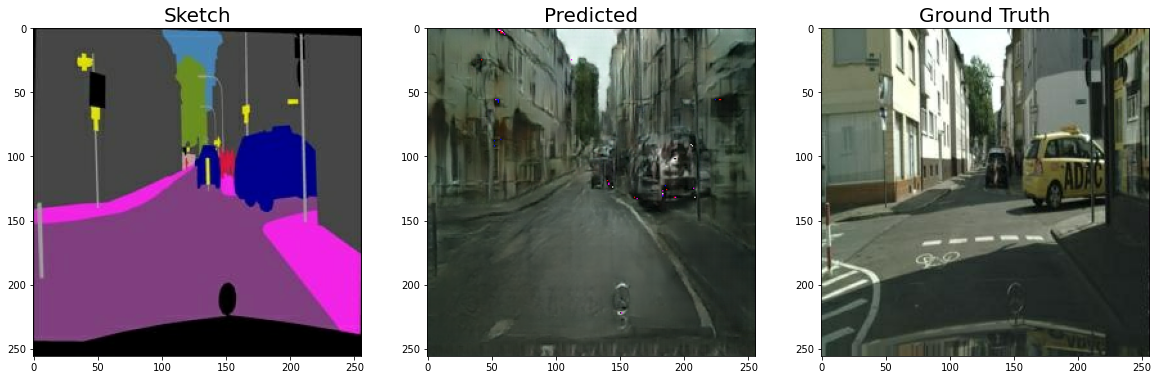

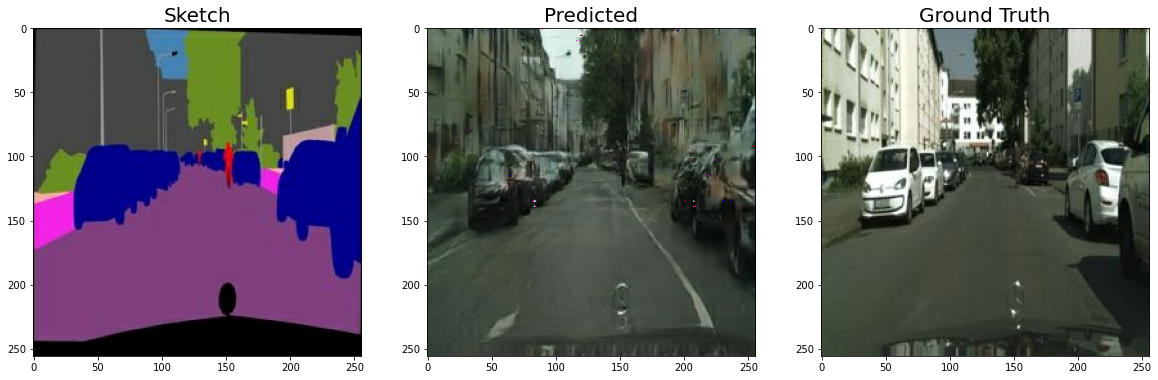

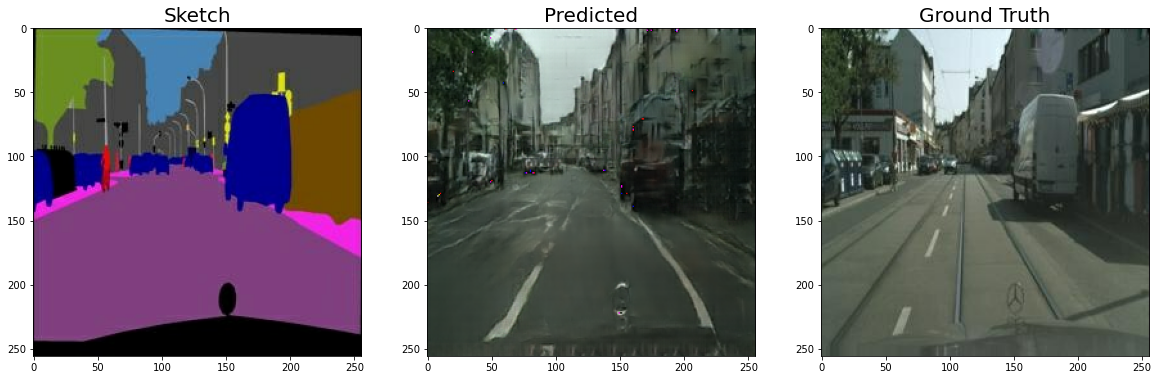

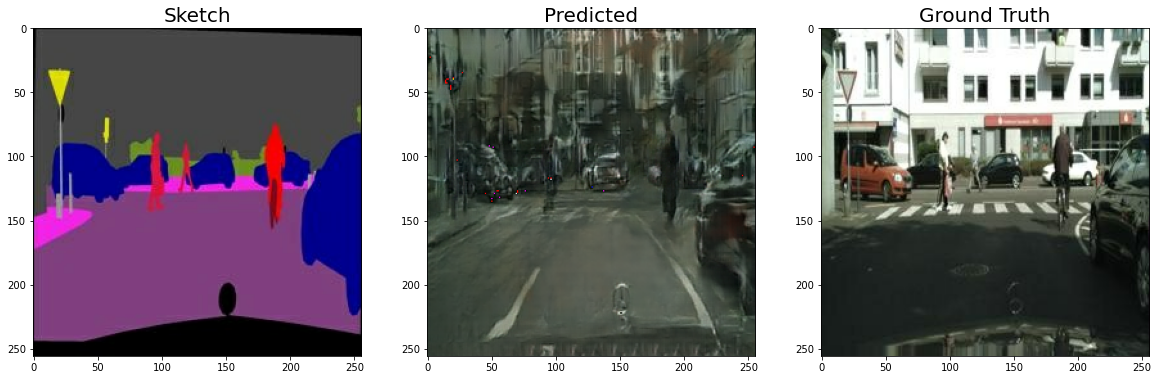

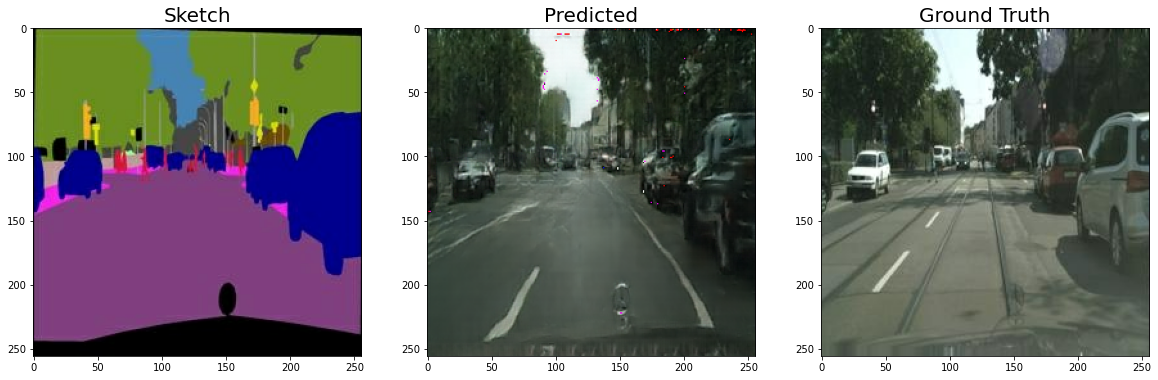

In [25]:
for sketch, colored in test_images:
    pred = generator(tf.expand_dims(sketch, 0))
    pred = denormalize(pred)

    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1)
    plt.imshow(denormalize(sketch))
    plt.title('Sketch', fontsize=20)
    plt.subplot(1,3,2)
    plt.imshow(pred[0])
    plt.title('Predicted', fontsize=20)
    plt.subplot(1,3,3)
    plt.imshow(denormalize(colored))
    plt.title('Ground Truth', fontsize=20)

실제 이미지에 비하면 이상한 부분이 많지만 도로의 차선 등  
나름 이미지를 만들어내고 있다. 

학습 중간 기록한 history로 부터 학습 과정을 그려보자.

In [26]:
history_file_prefix = ''
rcParams['figure.figsize'] = 15, 10

def draw_history(history, epoch_count):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['g_loss'])  
    plt.plot(history['d_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    #plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['f_acc'])  
    plt.plot(history['r_acc'])  
    plt.title('model accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig(f'save/{history_file_prefix}_history_{epoch_count:03d}.png')
    plt.show()

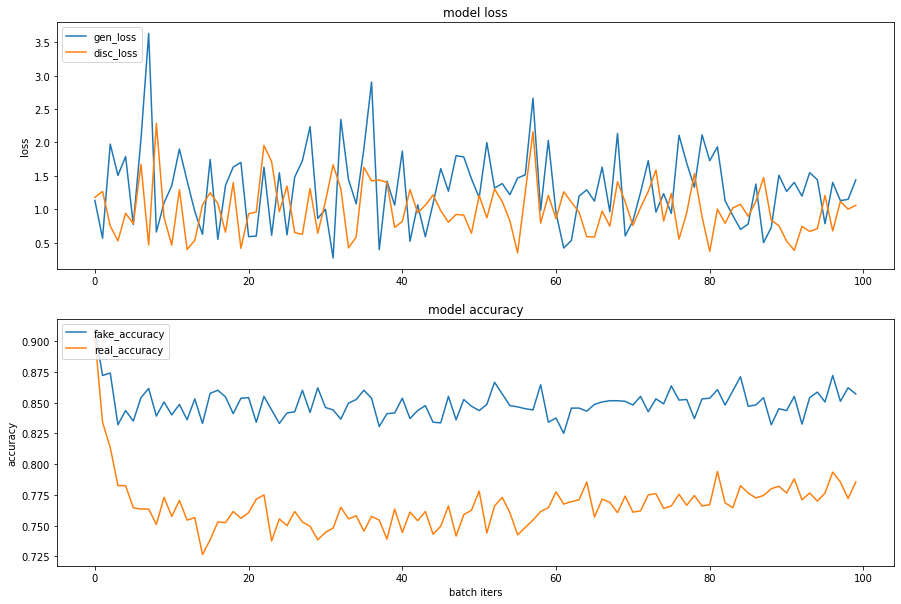

In [27]:
draw_history(history, EPOCHS)

학습 초반에는 오차값이 줄고 정확도도 0.5로  
줄어들다가 20epoch부터 큰 변화는 생기지 않는다.

다음은 매 epoch마다 저장한 test_image에 대한 generator의  
출력결과들을 gif로 만들어보자.

In [28]:
gif_path = 'save/sample_gif.gif'

with imageio.get_writer(gif_path, mode='I') as writer:
    filenames = glob.glob('images/sample*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

![SegmentLocal2](save/sample_gif.gif "segment")

## 회고

GAN에 이미지를 입력 조건으로서 학습하는 모델을 만들어보았다.  
100번의 epoch으로 학습했지만 그렇게 좋은 결과가 나오지 않았다.  

학습 그래프를 보면 20부터는 큰 변화가 없다. 오히려 끝에는 살짝 오차값이 커지기도한다.  
다만, 매 epoch마다 5장의 test_dataset으로부터 만들어낸 이미지를 비교해보면  
조금씩이나마 개선되는 것을 확인 할 수 있다.  

좋은 성능을 위해 GAN 모델을 학습시키는 여러 가지 방법을 사용한다면  
성능이 개선될지 나중에 테스트 해볼 생각이다.